# Instructions
For best results, run this notebook with 10x the friction on the gripper.

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize

import pydrake
from pydrake.all import (
    PiecewisePolynomial, RigidTransform, RotationMatrix, JacobianWrtVariable,
    MathematicalProgram
)

from src.drake_helpers import (
    get_basic_manip_station,
    BuildAndSimulateTrajectory, 
    setup_manipulation_station,
    visualize_transform,
    GripperControllerUsingIiwaState,
    GripperControllerUsingIiwaStateV2,
    GripperControllerUsingIiwaStateV3,
)
from src.ik import (
    create_q_knots, 
    pose_to_jointangles, 
    jointangles_to_pose, 
    spatial_velocity_jacobian_at_jointangles,
)
from src.throw import (
    plan_pickup,
    plan_prethrow_pose,
    add_go_to_ja_via_jointinterpolation,
    add_go_to_pose_via_jointinterpolation,
    plan_throw,
)
from src.trajectory import (
    get_launch_angle_required,
    get_launch_speed_required,
)

# cleaner debugging
np.set_printoptions(precision=3, suppress=True)

In [2]:
# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
print(web_url)

http://127.0.0.1:7000/static/


In [3]:
# Initialize global plants ONCE for IK calculations
# This speed up exectuation greatly.
GLOBAL_PLANT, GLOBAL_CONTEXT = get_basic_manip_station()

# Define throw problem

In [25]:
# Get initial pose of the gripper by using default context of manip station.
P_WORLD_TARGET = np.array([-2, 0, 4])
MAX_APPROACH_ANGLE = -45 / 180.0 * np.pi

GRIPPER_TO_OBJECT_FRAME_DIST = 0.12 # meters, this is how much "above" the balls origin we must send the gripper body frame in order to successfully grasp the object
OBJECT_FRAME_TO_COM_DIST = 0.05 / 2
GRIPPER_TO_OBJECT_COM_DIST = GRIPPER_TO_OBJECT_FRAME_DIST - OBJECT_FRAME_TO_COM_DIST

T_world_target = RigidTransform(RotationMatrix(), P_WORLD_TARGET)
T_world_objectInitial = RigidTransform(
    #p=[-.1, -.69, 1.04998503e-01], # sphere
    p=[-0.1  , -0.69 ,  0.09], # foam_brick
    R=RotationMatrix.MakeZRotation(np.pi/2.0)
)
T_world_gripperObject = RigidTransform(
    p=T_world_objectInitial.translation() + np.array([0, 0, GRIPPER_TO_OBJECT_FRAME_DIST]),
    R=RotationMatrix.MakeXRotation(-np.pi/2.0)
)

# Set starting and ending joint angles for throw
throw_heading = np.arctan2(P_WORLD_TARGET[1], P_WORLD_TARGET[0])
ja1 = throw_heading - np.pi
# TODO: edit these to work better for large angles.
PRETHROW_JA = np.array([ja1, 0, 0, 1.9, 0, -1.9, 0, 0, 0])
THROWEND_JA = np.array([ja1, 0, 0, 0.4, 0, -0.4, 0, 0, 0])
T_world_prethrowPose = jointangles_to_pose(
    plant=GLOBAL_PLANT,
    context=GLOBAL_CONTEXT,
    jointangles=PRETHROW_JA[:7],
)

T_world_robotInitial, meshcat = setup_manipulation_station(T_world_objectInitial, zmq_url, T_world_target)

#object frame viz
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
T_world_target = RigidTransform(
    p=P_WORLD_TARGET,
    R=RotationMatrix()
)
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
visualize_transform(meshcat, "target", T_world_target)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


### Compute release point via optimization
We use a scipy optimizer because a black-box optimizer is easy to implement.

In [26]:
def throw_objective(inp, g=9.81, alpha=1, return_launch_angle=False):
    throw_motion_time, release_frac = inp

    release_ja = PRETHROW_JA + release_frac * (THROWEND_JA - PRETHROW_JA)

    T_world_releasePose = jointangles_to_pose(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7]
    )
    p_release = (
        T_world_releasePose.translation()
      + T_world_releasePose.rotation().multiply([0, GRIPPER_TO_OBJECT_COM_DIST, 0])
    )

    J_release = spatial_velocity_jacobian_at_jointangles(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7],
        gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST # <==== important
    )[3:6]
    v_release = J_release @ ((THROWEND_JA - PRETHROW_JA) / throw_motion_time)[:7]

    x = np.linalg.norm((P_WORLD_TARGET - p_release)[:2])
    y = (P_WORLD_TARGET - p_release)[2]
    vx = np.linalg.norm(v_release[:2])
    vy = v_release[2]

    tta = x / vx
    y_hat = vy * tta - 0.5 * g * tta ** 2
    phi_hat = np.arctan((vy - g * tta) / vx)

    objective = (
        (p_release[2] + y_hat - P_WORLD_TARGET[2]) ** 2
      + alpha * np.maximum(phi_hat - MAX_APPROACH_ANGLE, 0) ** 2
      #+ alpha * (phi_hat - MAX_APPROACH_ANGLE) ** 2
    )
    
    if return_launch_angle:
        return np.arctan2(vy, vx)
    else:
        return objective

res = scipy.optimize.differential_evolution(
    throw_objective,
    bounds=[(1e-3, 3), (1e-3, 1 - 1e-3)],
)
"""
res = scipy.optimize.minimize(
    throw_objective,
    x0=np.array([0.3, 0.5]),
    method="nelder-mead",
    options={"xatol": 1e-8, "disp": False}
)
"""

print(f"Best objective value: {throw_objective(res.x)}")
assert throw_objective(res.x) < 1e-6, "Desired throw impossible?"

throw_motion_time, release_frac = res.x
assert throw_motion_time > 0
assert 0 < release_frac < 1

launch_angle = throw_objective(res.x, return_launch_angle=True)
print(f"Throw motion will take: {throw_motion_time:.4f} seconds")
print(f"Releasing at {release_frac:.4f} along the motion")
print(f"Launch angle (degrees): {launch_angle / np.pi * 180.0}")

release_ja = PRETHROW_JA + release_frac * (THROWEND_JA - PRETHROW_JA)
T_world_releasePose = jointangles_to_pose(
    plant=GLOBAL_PLANT,
    context=GLOBAL_CONTEXT,
    jointangles=release_ja[:7],
)


'''
timings
'''
t_goToObj = 1.0
t_holdObj = 0.5
t_goToPreobj = 1.0
t_goToWaypoint = 2.0
t_goToPrethrow = 4.0 # must be greater than 1.0 for a 1 second hold to stabilize
t_goToThrowEnd = throw_motion_time

Best objective value: 0.0
Throw motion will take: 0.1526 seconds
Releasing at 0.5429 along the motion
Launch angle (degrees): 80.38050790899848


In [27]:
def check_calc():
    # we need these states to calculate the jacobian
    ja1 = throw_heading - np.pi
    # you can play around with these to achieve different "release" poses
    release_ja = PRETHROW_JA + release_frac * (THROWEND_JA - PRETHROW_JA)
    T_world_releasePose = jointangles_to_pose(GLOBAL_PLANT, GLOBAL_CONTEXT, release_ja[:7])
    T_world_prethrowPose = jointangles_to_pose(GLOBAL_PLANT, GLOBAL_CONTEXT, PRETHROW_JA[:7])
    print(f"Release joint angles: {release_ja}")

    # calculate jacobian at release 
    J_G = spatial_velocity_jacobian_at_jointangles(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7],
        gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST # <==== important
    )
    J_G_joint4 = J_G[3:, 3] # spatial velocity only
    J_G_joint6 = J_G[3:, 5] # spatial velocity only
    J_G_joints46 = np.zeros((3, 2))
    J_G_joints46[:, 0] = J_G_joint4
    J_G_joints46[:, 1] = J_G_joint6
    print(J_G_joints46)

    # calculate angle at release
    release_spatial_dir = J_G_joints46 @ (THROWEND_JA - PRETHROW_JA)[[3, 5]]
    print(f"Release spatial direction: {release_spatial_dir}")
    angle_above_plane_rads = np.arctan2(
        release_spatial_dir[2],
        np.linalg.norm(release_spatial_dir[:2])
    )
    print(f"Throw angle (above xy plane) degs: {angle_above_plane_rads * 180.0 / np.pi}")

    # calculate required release velocity magnitude
    p_release = (
        T_world_releasePose.translation()
      + T_world_releasePose.rotation().multiply([0, GRIPPER_TO_OBJECT_COM_DIST, 0])
    )
    delta_x = np.linalg.norm(P_WORLD_TARGET[:2]) - np.linalg.norm(p_release[:2]) # dist on xy plane
    delta_y = P_WORLD_TARGET[2] - p_release[2] # height difference
    mag_v0_reqd = get_launch_speed_required(theta=angle_above_plane_rads, x=delta_x, y=delta_y)
    mag_v0_reqd = mag_v0_reqd
    print(f"Initial velocity magnitude: {mag_v0_reqd}")

    # calculate required time for throw motion
    time_reqd = np.linalg.norm(release_spatial_dir) / mag_v0_reqd
    print(f"time required: {time_reqd}")
    
    approach_angle = np.arctan(2 * delta_y / delta_x - np.tan(angle_above_plane_rads))
    print(f"Actual approach_angle (deg): {approach_angle * 180.0 / np.pi}")
    print(f"Max approach_angle (deg): {MAX_APPROACH_ANGLE * 180.0 / np.pi}")
    
check_calc()

Release joint angles: [ 0.     0.     0.     1.086  0.    -1.086  0.     0.     0.   ]
[[-0.023 -0.164]
 [ 0.    -0.   ]
 [-0.592  0.239]]
Release spatial direction: [-0.211 -0.     1.247]
Throw angle (above xy plane) degs: 80.3805079089985
Initial velocity magnitude: 8.287266142922583
time required: 0.15257612344503668
Actual approach_angle (deg): -52.45082568817687
Max approach_angle (deg): -45.0


### Visualize optimization problem

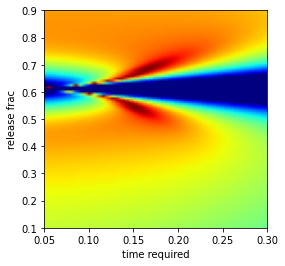

In [28]:
plt.figure(figsize=(4, 4))

X, Y = np.meshgrid(np.linspace(0.05, 0.3, 50), np.linspace(0.1, 0.9, 100))
Z = np.zeros_like(X).flatten()
for idx, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    Z[idx] = 1 - min(np.log(1 + throw_objective([x, y])), 6)
Z = Z.reshape(X.shape)

plt.pcolormesh(X,Y,Z, shading='gouraud', cmap='jet')
plt.xlabel("time required")
plt.ylabel("release frac")
plt.show();

#ax = plt.axes(projection="3d")
#ax.view_init(elev=20., azim=-45)
#ax.plot_surface(X, Y, Z, cmap="jet");
#ax.set_xlabel("time required");
#ax.set_ylabel("release frac");

# Generate trajectories in joint angle space with timings from above

### End-effector trajectory

In [29]:
# plan pickup
t_lst, q_knots, total_time = plan_pickup(T_world_robotInitial, T_world_gripperObject,
    t_goToObj=t_goToObj,
    t_holdObj=t_holdObj,
    t_goToPreobj=t_goToPreobj
)

# clear the bins via a waypoint
T_world_hackyWayPoint = RigidTransform(
    p=[-.6, -0.0, 0.6],
    R=RotationMatrix.MakeXRotation(-np.pi/2.0), #R_WORLD_PRETHROW, #RotationMatrix.MakeXRotation(-np.pi/2.0),
)
t_lst, q_knots = add_go_to_pose_via_jointinterpolation(
    T_world_robotInitial, 
    T_world_hackyWayPoint, 
    t_start=total_time,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToWaypoint
)

# go to prethrow
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    pose_to_jointangles(T_world_hackyWayPoint), 
    PRETHROW_JA, 
    t_start=total_time + t_goToWaypoint,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToPrethrow,
    hold_time_s=1.0,
)

# go to throw
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    PRETHROW_JA,
    THROWEND_JA,
    t_start=total_time + t_goToWaypoint + t_goToPrethrow,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToThrowEnd,
    num_samples=30,
    include_end=True
)

# turn trajectory into joint space
q_knots = np.array(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)

### Gripper trajectory

In [30]:
# make gripper trajectory
gripper_times_lst = np.array([
    0.,
    t_goToObj,
    t_holdObj,
    t_goToPreobj,
    t_goToWaypoint,
    t_goToPrethrow,
    release_frac * t_goToThrowEnd,
    1e-9,
    (1 - release_frac) * t_goToThrowEnd,
])
gripper_cumulative_times_lst = np.cumsum(gripper_times_lst)
GRIPPER_OPEN = 0.5
GRIPPER_CLOSED = 0.0
gripper_knots = np.array([
    GRIPPER_OPEN,
    GRIPPER_OPEN,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_OPEN,
    GRIPPER_OPEN,
]).reshape(1, gripper_times_lst.shape[0])
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_cumulative_times_lst, gripper_knots)

### Visualizing trajectories

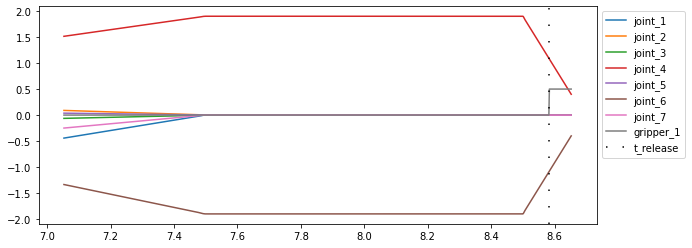

In [31]:
plt.figure(figsize=(10, 4))

viz_times = np.linspace(q_traj.end_time() - 1.6, q_traj.end_time(), 1000)
q_plan = np.hstack([q_traj.value(t) for t in viz_times])
g_plan = np.hstack([g_traj.value(t) for t in viz_times])

for idx, r in enumerate(q_plan):
    plt.plot(viz_times, r, label=f"joint_{idx + 1}")
for idx, r in enumerate(g_plan):
    plt.plot(viz_times, r, label=f"gripper_{idx + 1}")
    
plt.axvline(
    x=gripper_cumulative_times_lst[-2],
    color="black", linestyle=(0, (1, 10)), label="t_release"
);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

# Run simulation

In [34]:
get_gripper_controller_1 = lambda station_plant: GripperControllerUsingIiwaState(
    plant=station_plant,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    T_world_targetRelease=T_world_releasePose,
    dbg_state_prints=False,
)

# doesn't release for the (-6, 6, -1)
get_gripper_controller_2 = lambda station_plant: GripperControllerUsingIiwaStateV2(
    plant=station_plant,
    gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    p_world_target=T_world_target.translation(),
    planned_launch_angle=launch_angle,
    launch_angle_thresh=0.03,
    height_thresh=5, # tunable parameter
    dbg_state_prints=True
)

# doesn't release for the (-6, 6, -1)
get_gripper_controller_3 = lambda station_plant: GripperControllerUsingIiwaStateV3(
    plant=station_plant,
    gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    planned_launch_angle=launch_angle,
    launch_angle_thresh=3/ 180.0 * np.pi,
    dbg_state_prints=True
)

# do the thing
simulator, station_plant, meshcat, loggers = BuildAndSimulateTrajectory(
    q_traj=q_traj,
    g_traj=g_traj,
    get_gripper_controller=get_gripper_controller_3,
    T_world_objectInitial=T_world_objectInitial, # where to init the object in the world
    T_world_targetBin=T_world_target, # where the ball should hit - aka where the bin will catch it
    zmq_url=zmq_url,
    time_step=1e-3, # target (-6, 6, -1). 1e-3 => overshoot barely, 1e-4 => undershoot barely, look around 7.92-7.94 s in sim
    include_target_bin=True
)

visualize_transform(
    meshcat,
    "TARGET",
    RigidTransform(RotationMatrix.MakeZRotation(0), P_WORLD_TARGET),
    prefix='',
    length=0.3,
    radius=0.02
)

fly_time = 2
meshcat.start_recording()
print(f"Throw motion should happen from 6.5 seconds to {6.5 + throw_motion_time} seconds")
print(f"Running for {q_traj.end_time() + fly_time} seconds")
simulator.AdvanceTo(q_traj.end_time() + fly_time)
#simulator.AdvanceTo(1.5)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
Throw motion should happen from 6.5 seconds to 6.652576123445037 seconds
Running for 10.652576123445037 seconds
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
v2d=(1.75, 8.53) launch_angles=(78.40, 80.38)
v2d=(1.61, 8.60) launch_angles=(79.37, 80.38)
v2d=(1.48, 8.68) launch_angles=(80.34, 80.38)
v2d=(1.34, 8.75) launch_angles=(81.31, 80.38)
v2d=(1.19, 8.81) launch_angles=(82.29, 80.38)
v2d=(1.05, 8.88) launch_angles=(83.26, 80.38)
v2d=(0.90, 8.94) launch_angles=(84.24, 80.38)
RELEASING!
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY


### Simulation visualization (+ comparison with plan)

Approx release time: 8.626


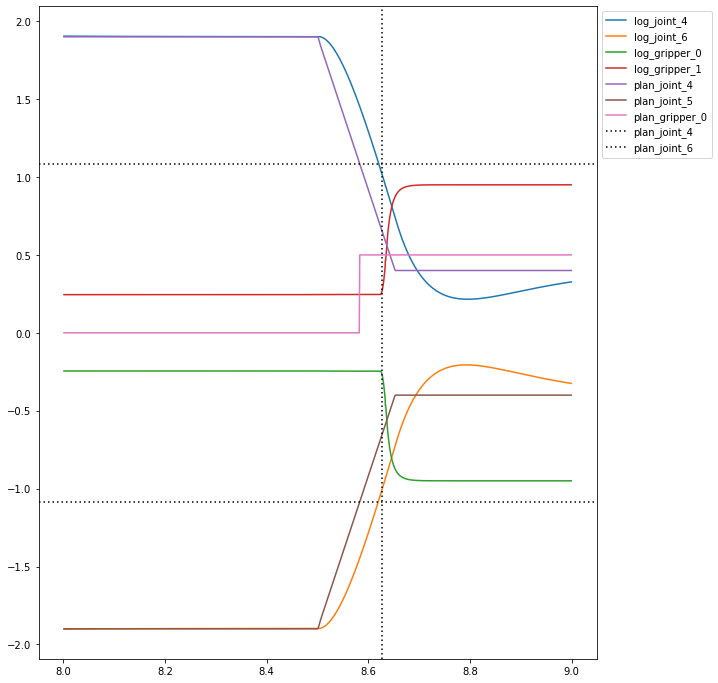

In [35]:
plt.figure(figsize=(10, 12))

all_log_times = loggers["state"].sample_times()
chosen_idxs = (8 < all_log_times) & (all_log_times < 9)

log_times = loggers["state"].sample_times()[chosen_idxs]
log_states = loggers["state"].data()[:, chosen_idxs]

for idx, r in enumerate(log_states[[10, 12]]):
    plt.plot(log_times, r, label=f"log_joint_{2*idx+4}")
for idx, r in enumerate(log_states[[14, 15]]):
    plt.plot(log_times, 10 *r, label=f"log_gripper_{idx}")
    
q_plan = np.hstack([q_traj.value(t) for t in log_times])
g_plan = np.hstack([g_traj.value(t) for t in log_times])
for idx, r in enumerate(q_plan[[3, 5]]):
    plt.plot(log_times, r, label=f"plan_joint_{idx + 4}")
for idx, r in enumerate(g_plan):
    plt.plot(log_times, r, label=f"plan_gripper_{idx}")

for idx in [4, 6]:
    plt.axhline(
        y=release_ja[idx-1],
        color="black", linestyle=(0, (1, 2)), label=f"plan_joint_{idx}"
    );

approx_release_idx = np.where(log_states[15] > log_states[15].min() + 1e-3)[0][0]
approx_release_time = log_times[approx_release_idx]
print(f"Approx release time: {approx_release_time}")
plt.axvline(
    x=approx_release_time,
    color="black", linestyle=(0, (1, 2)), label=""
);

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

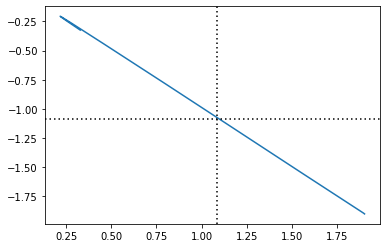

In [36]:
plt.plot(log_states[10], log_states[12]);
plt.axvline(
    x=release_ja[3],
    color="black", linestyle=(0, (1, 2))
);
plt.axhline(
    y=release_ja[5],
    color="black", linestyle=(0, (1, 2))
);

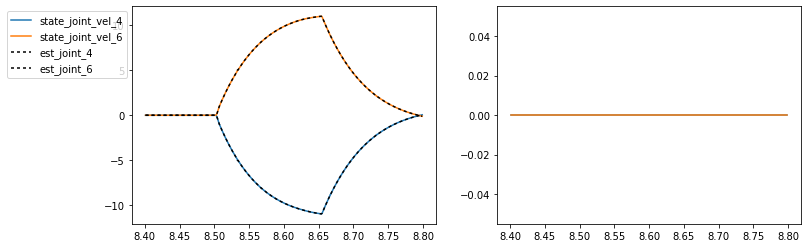

In [38]:
plt.figure(figsize=(12, 4))

all_log_times = loggers["state"].sample_times()
chosen_idxs = (8.4 < all_log_times) & (all_log_times < 8.8)

chosen_times = loggers["state"].sample_times()[chosen_idxs]
chosen_states = loggers["state"].data()[:, chosen_idxs]
chosen_v_est = loggers["v_est"].data()[:, chosen_idxs]

plt.subplot(1, 2, 1)
for idx, r in enumerate(chosen_states[[25, 27]]):
    plt.plot(chosen_times, r, label=f"state_joint_vel_{2*idx+4}")

for idx, r in enumerate(chosen_v_est[[3, 5]]):
    plt.plot(
        chosen_times, r, label=f"est_joint_{2*idx+4}",
        linestyle=(0, (2, 2)), color="black"
    )
plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1);

plt.subplot(1, 2, 2)
for idx, (r1, r2) in enumerate(
    zip(chosen_states[[25, 27]], chosen_v_est[[3, 5]])
):
    plt.plot(chosen_times, r1 - r2, label=f"diff_joint_vel_{2*idx+4}")

In [40]:
context = simulator.get_context()
station_plant.GetPositions(
    station_plant.GetMyContextFromRoot(context),
    #station_plant.GetModelInstanceByName("sphere")
    station_plant.GetModelInstanceByName("foam_brick")
)

array([-0.461, -0.   , -0.   ,  0.988, -2.087,  0.028,  4.015])